# 사전 사용 패키지 다운로드

In [1]:
import pandas as pd # 데이터 전처리
import numpy as np # 데이터 전처리
import random #데이터 전처리
from pandas import DataFrame #데이터 전처리
from collections import Counter #데이터 전처리

from tqdm import tqdm #시간 측정용

import pickle # 저장
from keras.models import load_model # 모델로드
from keras.models import model_from_json # 모델저장

%matplotlib inline 
import matplotlib.pyplot as plt # 플로팅
from matplotlib import style; style.use('ggplot')
import re # 문자열 다듬기

from keras.models import load_model
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer # 토크나이저
from tensorflow.keras.layers import Embedding, Dense, LSTM # 모델 세팅
from tensorflow.keras.models import Sequential 
from tensorflow.keras.preprocessing.sequence import pad_sequences # 인풋 패딩

from sklearn.metrics import roc_curve # 모델 성능 확인
from sklearn.metrics import roc_auc_score  
from sklearn.metrics import auc
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import classification_report

from sklearn.model_selection import train_test_split  # 인풋 스플릿

Using TensorFlow backend.


# 대회 데이터 다운로드

In [2]:
from google.colab import drive

drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


일반적으로 들어가지는 구글드라이브에  데이콘, Mission14라는 폴더를 만들고 그 안에 경진대회의 데이터를 이동시켜놓았다

In [3]:
!ls "/content/gdrive/My Drive/데이콘, Mission14" #현재 drive 경로 안의 파일 or 폴더 표시

 1222첫시도			  'Copy of 14회_colab_baseline.ipynb'
 1222_1022_jh_data_setting.ipynb   Mecab-ko-for-Google-Colab
 1222_1022_jh_model_code.ipynb	   public_test.csv
 12221022jhmodel.json		   submission_제출양식.csv
 12221022jhweights.h5		   train.csv
 14회_colab_baseline.ipynb


In [4]:
cd /content/gdrive/My Drive/데이콘, Mission14

/content/gdrive/My Drive/데이콘, Mission14


In [0]:
#데이터 로드
'''
mecab_train_x_jh0.5 사용
1. 전체 데이터셋 중 5000/5000 랜덤 분할
2. 토크나이저 mecab.nouns 사용
3. 스탑워즈 ['XXX', '.', '을', '를', '이', '가', '-', '(', ')', ':', 
             '!', '?', ')-', '.-', 'ㅡ', 'XXXXXX', '..', '.(', '은', '는'] 사용
'''

with open('/content/gdrive/My Drive/데이콘, Mission14/Mecab-ko-for-Google-Colab/mecab_nouns_balance_train.pickle', 'rb') as f:
  train_data = pickle.load(f)
with open('/content/gdrive/My Drive/데이콘, Mission14/Mecab-ko-for-Google-Colab/mecab_nouns_balance_test.pickle', 'rb') as f:
  test_data = pickle.load(f)

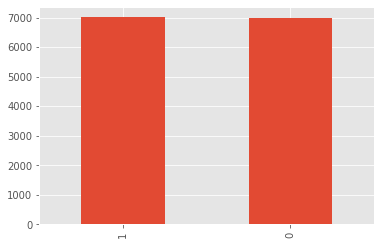

In [6]:
#트레인셋 클래스 균형 확인
train_data['label'].value_counts().plot(kind='bar')

In [7]:
#트레인셋 관련 정보
print(train_data.groupby('label').size().reset_index(name='count')) # 클래스당 데이터 개수
print('---------------------------------------')
print('결측치 포함 여부: ',train_data.isnull().values.any()) # 결측치 포함 여부
print('---------------------------------------')
print('총 트레인 데이터 개수: ',len(train_data)) # 트레인 데이터 총 개수

   label  count
0      0   6990
1      1   7010
---------------------------------------
결측치 포함 여부:  False
---------------------------------------
총 트레인 데이터 개수:  14000


In [8]:
train_data

,text,label
0,"[광고, 안녕, 대출, 수수료, 입금, 요구, 고금리, 대출, 저금리, 대출, 전화...",1
1,"[광고, 광고, 은행, 정확, 신용, 대출, 당사, 상품, 자격, 기준, 심사, 기...",1
2,"[화요일, 화사, 시작, 날, 웃음, 하루, 포, 점]",0
3,"[고객, 안녕, 정성, 고객, 생신, 축하]",0
4,"[고객, 안녕, 전담, 직원, 은행, 인천, 원당, 지점, 과장, 점, 문, 사항,...",0
...,...,...
13995,"[추석, 휴일, 안내, 토, 월, 영업, 일, 응암, 오거리]",0
13996,"[생동, 봄, 기운, 기분, 주말, 장항동, 부, 지점장, 드림]",0
13997,"[광고, 문자, 광고, 여신상, 품부, 저희, 국민, 은행, 이용, 감사, 년, 하...",1
13998,"[고객, 감사, 일, 월, 중, 으뜸, 어버이날, 식사, 안부, 전화, 통, 부모,...",0


In [0]:
train_X = train_data['text'].values
train_y = train_data['label'].values
test_X = test_data['text'].values
test_y = test_data['label'].values

In [0]:
#임베딩 tensorflow.keras.preprocessing.text 내부 Tokenizer
max_features = 35000
tokenizer = Tokenizer(num_words=max_features) # 상위 35,000개의 단어만 보존 / 임의
tokenizer.fit_on_texts(train_X)
X_train = tokenizer.texts_to_sequences(train_X)
X_test = tokenizer.texts_to_sequences(test_X)

In [17]:
#단어:숫자 매칭 결과
print(tokenizer.word_index)

{'가능': 1, '상품': 2, '분': 3, '금리': 4, '대출': 5, '등급': 6, '상담': 7, '은행': 8, '신용': 9, '한도': 10, '신청': 11, '원': 12, '고객': 13, '부채': 14, '진행': 15, '수': 16, '통합': 17, '거부': 18, '문자': 19, '만': 20, '월': 21, '이상': 22, '전화': 23, '금융': 24, '중': 25, '광고': 26, '추가': 27, '직장': 28, '년': 29, '전환': 30, '사용': 31, '수신': 32, '방식': 33, '방법': 34, '이용': 35, '이자': 36, '자격': 37, '안내': 38, '등': 39, '자금': 40, '적용': 41, '최대': 42, '대환': 43, '감사': 44, '원리금': 45, '카드': 46, '차등': 47, '관리': 48, '조건': 49, '지원': 50, '도움': 51, '채무': 52, '상환': 53, '서비스': 54, '거래': 55, '자체': 56, '답장': 57, '무료': 58, '시': 59, '건수': 60, '억': 61, '최저': 62, '일': 63, '번': 64, '대비': 65, '조회': 66, '시간': 67, '연락': 68, '건': 69, '기준': 70, '균': 71, '기간': 72, '접수': 73, '지점': 74, '대상': 75, '최고': 76, '기업': 77, '필요': 78, '현금': 79, '정부': 80, '희망': 81, '연봉': 82, '저희': 83, '개월': 84, '상승': 85, '최근': 86, '내용': 87, '번호': 88, '금액': 89, '만기': 90, '세': 91, '행복': 92, '기존': 93, '시중': 94, '판단': 95, '후': 96, '대': 97, '연체': 98, '부탁': 99, '안녕': 100, '확인': 101, '개인': 102, 

In [0]:
#훈련된 토크나이저 저장 / 추후 테스트셋에 임베딩용으로 사용
with open('12221022tokenizer_jh.pickle', 'wb') as f:
  pickle.dump(tokenizer, f)

문자의 최대 길이 : 285
문자의 평균 길이 : 93.97642857142857


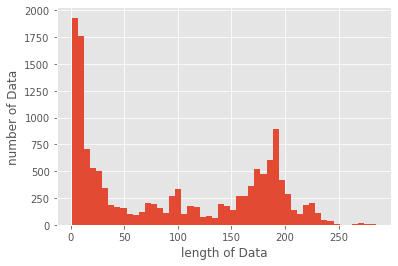

In [19]:
#훈련셋 관련 정보
print('문자의 최대 길이 :',max(len(l) for l in X_train))
print('문자의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('length of Data')
plt.ylabel('number of Data')
plt.show()

In [0]:
#인풋 데이터 패딩 / NN모델 입력시 인풋데이터 쉐잎 통일을 위함
max_len=200 # 전체 데이터의 길이는 200으로 맞춤
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

In [0]:
#클래스 세팅
y_train=np.array(train_y)
y_test=np.array(test_y)

In [23]:
#모델 생성
model = Sequential()
model.add(Embedding(max_features, 100))
model.add(LSTM(128))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=5, batch_size=32, validation_split=0.3)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 9800 samples, validate on 4200 samples
Epoch 1/5
9800/9800 [==============================] - 89s 9ms/sample - loss: 0.0477 - acc: 0.9873 - val_loss: 0.0053 - val_acc: 0.9993
Epoch 2/5
9800/9800 [==============================] - 87s 9ms/sample - loss: 0.0039 - acc: 0.9994 - val_loss: 0.0064 - val_acc: 0.9990
Epoch 3/5
9800/9800 [==============================] - 87s 9ms/sample - loss: 0.0024 - acc: 0.9997 - val_loss: 0.0069 - val_acc: 0.9990
Epoch 4/5
9800/9800 [==============================] - 86s 9ms/sample - loss: 0.0017 - acc: 0.9998 - val_loss: 0.0080 - val_acc: 0.9988
Epoch 5/5
9800/9800 [==============================] - 86s 9ms/sample - loss: 0.0030 - acc: 0.9995 - val_loss: 0.00

In [24]:
#모델 저장 / json형식 / 가중치 제외
date='1222'
time='1022'
writer='jh'
save_model_name = date+time+writer+'model.json'
save_weights_name = date+time+writer+'weights.h5'

model_json = model.to_json()
with open(save_model_name, "w") as json_file : 
    json_file.write(model_json)

#가중치 저장 / h5형식
model.save_weights(save_weights_name)

print('Saved model to disk')

Saved model to disk


In [25]:
#테스트 셋에 대한 예측확률값 저장
pred_val = model.predict(X_test)
print(len(pred_val)) #전체 길이

6000


이놈의 AUC값은?  0.9999395548839431


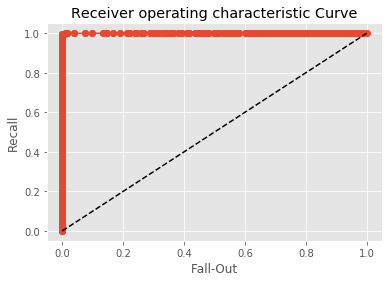

In [26]:
#AUC계산을 위한 fpr, tpr 계산
fpr, tpr, thresholds = roc_curve(y_test, pred_val)

#AUC계산
print('이놈의 AUC값은? ',auc(fpr, tpr))

#ROC커브 플로팅
plt.plot(fpr, tpr, 'o-', label="LSTM")
plt.plot([0, 1], [0, 1], 'k--', label="random guess")
# plt.plot([fallout], [recall], 'ro', ms=10)
plt.xlabel('Fall-Out')
plt.ylabel('Recall')
plt.title('Receiver operating characteristic Curve')
plt.show()

In [27]:
# 에측 똑바로 하셨는지 확인
y_pred = []
for pred_val_ in pred_val:
  if pred_val_>=0.5:
    y_pred.append(1)
  else: y_pred.append(0)
df = pd.DataFrame({"y_test":y_test, "y_pred":y_pred, "y_prob":pred_val.flatten()})
df

,y_test,y_pred,y_prob
0,0,0,0.000067
1,1,1,0.999318
2,0,0,0.000086
3,0,0,0.000099
4,1,1,0.999515
...,...,...,...
5995,1,1,0.999341
5996,1,1,0.998607
5997,0,0,0.000140
5998,1,1,0.999618


In [28]:
#예측 똑바로 하셨는지 확인2
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=['class 0', 'class 1']))

[[2998   12]
 [   4 2986]]
              precision    recall  f1-score   support

     class 0       1.00      1.00      1.00      3010
     class 1       1.00      1.00      1.00      2990

    accuracy                           1.00      6000
   macro avg       1.00      1.00      1.00      6000
weighted avg       1.00      1.00      1.00      6000



#해당 모델로 Submission 파일 만들기

In [0]:
#퍼블릭 테스트 데이터 로드
with open('/content/gdrive/My Drive/데이콘, Mission14/Mecab-ko-for-Google-Colab/mecab_nouns_public_test.pickle', 'rb') as f:
  public_test_data = pickle.load(f)

#토크나이저 로드
with open('/content/gdrive/My Drive/데이콘, Mission14/12221022jhtokenizer.pickle', 'rb') as f:
  tokenizer = pickle.load(f)

In [39]:
X_public_test = public_test_data['text'].values
X_public_test

array([list(['고객', '시작', '주', '행복', '기원', '지난주', '글로벌', '증시', '파월', '미', '연준', '의장', '통화', '정책', '완화', '태도', '변화', '것', '주초', '투자', '심리', '개선', '폭', '상승', '마감', '미', '중', '차관', '급', '무역', '협상', '순조', '진행', '점', '긍정', '원', '달러', '환율', '주간', '원', '하락', '가운데', '외국인', '투자자', '국내', '증시', '순', '매수', '규모', '천억', '상회', '수급', '개선', '점', '주목', '필요', '금주', '시장', '미국', '금융', '주', '실적', '발표', '시작', '본격', '실적', '시즌', '진입', '지난주', '애플', '삼성전자', '등', '주요', '기업', '분기', '실적', '전망', '하향', '조정', '점', '참고', '올해', '글로벌', '성장', '둔화', '기조', '속', '기업', '순익', '감소', '추이', '관심', '필요', '후반', '브렉', '시트', '영국', '하원', '표결', '예정', '날씨', '건강', '유의', '주', '감사', '은행', '송도', '센터']),
       list(['긴급', '안내', '은행', '가락동', '지점', '헬리오', '기본', '대출', '이자', '조합', '납부', '년', '월', '일부', '종료', '년', '월', '일', '일', '중도금', '대출', '이자', '계약자', '납부', '방법', '안내', '자동', '등록', '은행', '영업', '점', '본인', '방문', '신분증', '지참', '직원', '대출', '계좌', '대출', '자동', '납부', '계좌', '간', '자동', '등록', '요청', '인터넷', '뱅킹', '공인', '증서', '로그인', '후', '자동', '등록', '자동', '등록'

In [0]:
#임베딩 및 패딩
X_public_test = tokenizer.texts_to_sequences(X_public_test)
max_len=200 # 전체 데이터의 길이는 200으로 맞춘다.
X_public_test = pad_sequences(X_public_test, maxlen=max_len)

In [42]:
#모델 로드
json_file = open("/content/gdrive/My Drive/데이콘, Mission14/12221022jhmodel.json", "r") 
loaded_model_json = json_file.read() 
json_file.close() 

loaded_model = tf.keras.models.model_from_json(loaded_model_json)

#가중치로드
loaded_model.load_weights("/content/gdrive/My Drive/데이콘, Mission14/12221022jhweights.h5") 

print("Loaded model from disk")

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Loaded model from disk


In [0]:
#모델, 가중치 합체!
loaded_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [0]:
#예측 고고싱
y_public_test_pred=loaded_model.predict(X_public_test)

In [45]:
#submission 만들기
!ls "/content/gdrive/My Drive/데이콘, Mission14" #파일저장 경로 세팅

 1222첫시도			   14회_colab_baseline.ipynb
 1222_1022_jh_data_setting.ipynb  'Copy of 14회_colab_baseline.ipynb'
 1222_1022_jh_model_code.ipynb	   Mecab-ko-for-Google-Colab
 12221022jhmodel.json		   public_test.csv
 12221022jhweights.h5		   submission_제출양식.csv
 12221022tokenizer_jh.pickle	   train.csv


In [46]:
cd /content/gdrive/My Drive/데이콘, Mission14

/content/gdrive/My Drive/데이콘, Mission14


In [0]:
submission=pd.read_csv("submission_제출양식.csv") #양식 로드

submission['smishing'] = y_public_test_pred #예측확률값 채워넣기

submission.to_csv("12221022jhsubmission.csv",index=False) #파일 저장

#하단부 무시

In [0]:
# y_test_onehot = pd.get_dummies(y_test)
# y_test_onehot

In [0]:
# import keras
# y_test_categorical = keras.utils.np_utils.to_categorical(y_test, num_classes=2, dtype='float32')
# y_test_categoricalkeras

In [129]:
# from tensorflow.keras.layers import Embedding, Dense, LSTM
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.metrics import AUC

# model = Sequential()
# model.add(Embedding(max_words, 150))
# model.add(LSTM(1024))
# model.add(Dense(1, activation='softmax'))

# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['AUC'])
# history = model.fit(X_train, y_train, epochs=4, batch_size=512, validation_split=0.2)

Train on 5600 samples, validate on 1400 samples
Epoch 1/4
5600/5600 [==============================] - 11s 2ms/sample - loss: 7.6721 - auc_6: 0.5000 - val_loss: 7.7227 - val_auc_6: 0.5000
Epoch 2/4
5600/5600 [==============================] - 10s 2ms/sample - loss: 7.6721 - auc_6: 0.5000 - val_loss: 7.7227 - val_auc_6: 0.5000
Epoch 3/4
5600/5600 [==============================] - 10s 2ms/sample - loss: 7.6721 - auc_6: 0.5000 - val_loss: 7.7226 - val_auc_6: 0.5000
Epoch 4/4
5600/5600 [==============================] - 10s 2ms/sample - loss: 7.6721 - auc_6: 0.5000 - val_loss: 7.7227 - val_auc_6: 0.5000


In [182]:
# y_test

array([0, 1, 1, ..., 0, 0, 0])